In [3]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.pseudo_utils as pseudo_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.behavioral_utils as behavioral_utils
from utils.session_data import SessionData

import json

from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)

import matplotlib.pyplot as plt
import matplotlib

from dPCA.dPCA import dPCA

In [4]:
PRE_INTERVAL = 1300
POST_INTERVAL = 1500
INTERVAL_SIZE = 10
EVENT = "FeedbackOnset"
N_BLOCKS_OF_RULE = 5

# output dir that was specified in the decode_features_with_pseudo.py
OUTPUT_DIR = "/data/patrick_scratch/pseudo"

SESSIONS_PATH = f"/data/patrick_scratch/multi_sess/valid_sessions_more_than_{N_BLOCKS_OF_RULE}_of_rule.pickle"

DECODING_NAME = "is_rule_or_not_last_5_cors"

FEATURE_TO_DIM = {
    'CIRCLE': 'Shape', 
    'SQUARE': 'Shape', 
    'STAR': 'Shape', 
    'TRIANGLE': 'Shape', 
    'CYAN': 'Color', 
    'GREEN': 'Color', 
    'MAGENTA': 'Color', 
    'YELLOW': 'Color', 
    'ESCHER': 'Pattern', 
    'POLKADOT': 'Pattern', 
    'RIPPLE': 'Pattern', 
    'SWIRL': 'Pattern'
}

SEED = 42

In [5]:
feature = "SQUARE"

valid_sess = pd.read_pickle(SESSIONS_PATH)
valid_sess[valid_sess[feature]]

,session_datetime,session_count,session_name,valid,CIRCLE,SQUARE,STAR,TRIANGLE,CYAN,GREEN,MAGENTA,YELLOW,ESCHER,POLKADOT,RIPPLE,SWIRL
5,2018-07-09,0,20180709,True,False,True,True,False,False,False,False,False,False,False,False,False
13,2018-08-06,0,20180806,True,True,True,False,True,False,False,False,False,False,False,False,False
42,2018-08-02,0,20180802,True,True,True,False,True,True,True,False,True,False,False,False,False
46,2018-08-30,0,20180830,True,False,True,False,False,True,False,False,False,False,False,False,False
66,2018-09-26,0,20180926,True,False,True,False,False,False,False,False,False,False,False,False,False


In [6]:
sess_name = "20180802"
behavior_path = f"/data/rawdata/sub-SA/sess-{sess_name}/behavior/sub-SA_sess-{sess_name}_object_features.csv"
beh = pd.read_csv(behavior_path)
valid_beh = behavioral_utils.get_valid_trials(beh)
valid_beh = behavioral_utils.get_last_n_corrects_per_block(valid_beh, 5)
# get last N corrects
# label trial with whether the feature is rule or not
valid_beh["IsRule"] = valid_beh.CurrentRule == feature
feature_selections = behavioral_utils.get_selection_features(valid_beh)
valid_beh = pd.merge(valid_beh, feature_selections, on="TrialNumber", how="inner")
# only look at trials where monkey chose a card containing the feature we're looking at
feature_dim = FEATURE_TO_DIM[feature]
valid_beh = valid_beh[valid_beh[feature_dim] == feature]

# balance the dataset
is_rule = valid_beh[valid_beh.IsRule]
not_rule = valid_beh[~valid_beh.IsRule]
num_trials_per = np.min((len(is_rule), len(not_rule)))
print(f"{num_trials_per} trials for each condition in session {sess_name}")
trials = pd.concat([
    is_rule.sample(num_trials_per, random_state=SEED),
    not_rule.sample(num_trials_per, random_state=SEED),
])

25 trials for each condition in session 20180802


In [18]:
frs_path = f"/data/patrick_scratch/multi_sess/{sess_name}/{sess_name}_firing_rates_0_{EVENT}_{POST_INTERVAL}_{INTERVAL_SIZE}_bins_10_smooth.pickle"
frs = pd.read_pickle(frs_path)

In [19]:
merged = pd.merge(trials, frs, on="TrialNumber", how="inner")
merged = merged[["TrialNumber", "UnitID", "TimeBins", "IsRule", "FiringRate"]]

In [20]:
means = merged.groupby(["UnitID", "TimeBins", "IsRule"]).mean().reset_index()
means = means.sort_values(["UnitID", "TimeBins", "IsRule"])
np_arr = means["FiringRate"].to_numpy()

In [27]:
num_units = len(merged.UnitID.unique())
num_timebins = len(merged.TimeBins.unique())
num_is_rules = 2
data = np_arr.reshape((num_units, num_timebins, num_is_rules))

In [28]:
data.shape

(46, 150, 2)

In [29]:
# dpca = dPCA(labels='tr', join={'tr' : ['r','tr']})
dpca = dPCA(labels='tr')
dpca.protect = ['t']
res = dpca.fit_transform(data)

In [30]:
rs = means.IsRule.unique()

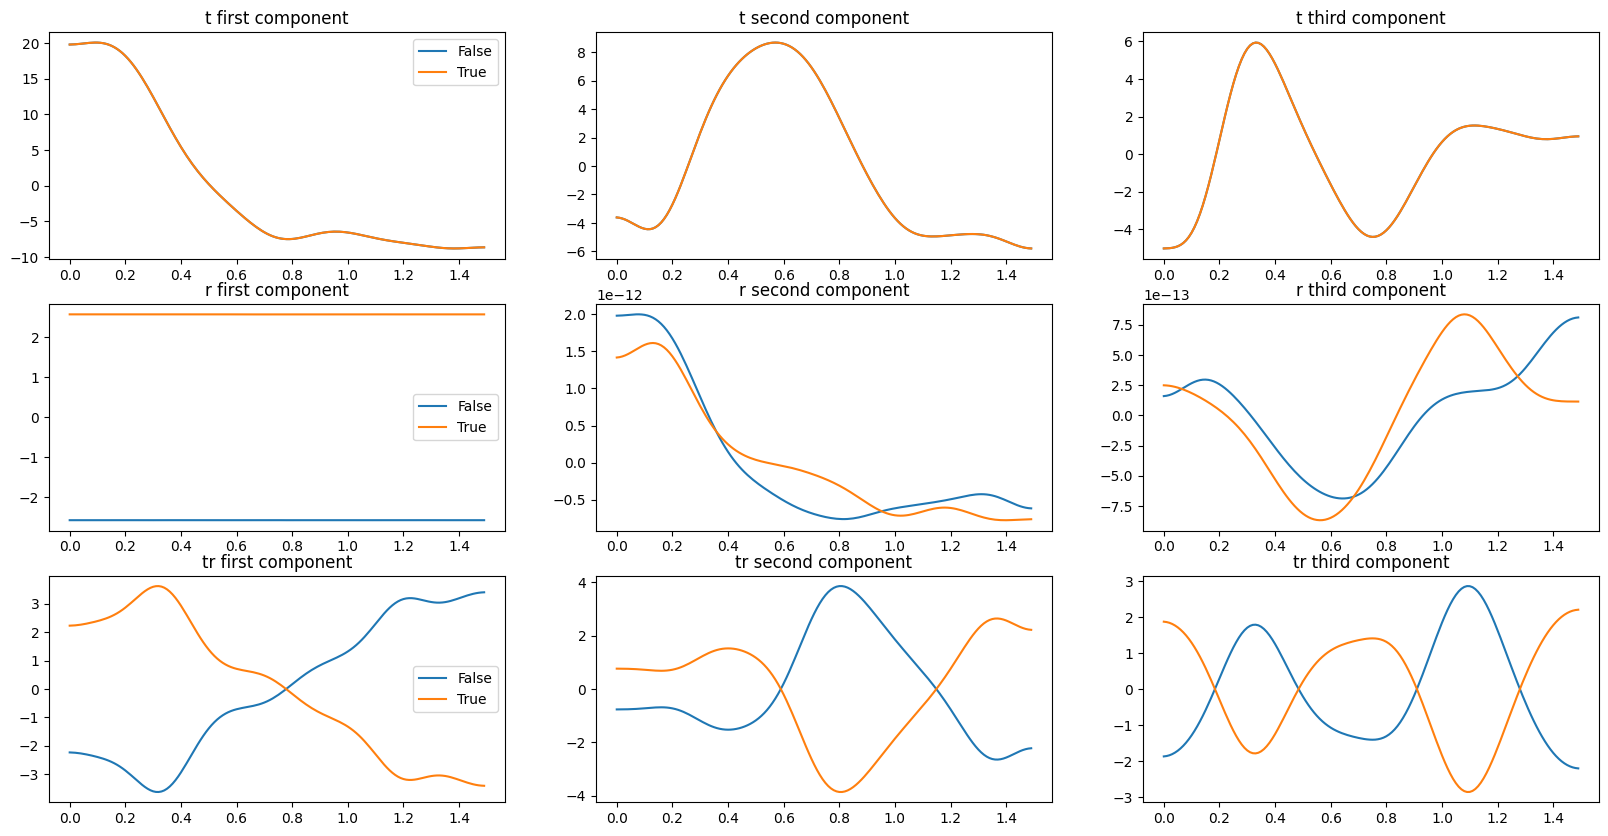

In [31]:
fig, axs = plt.subplots(3, 3, figsize=(20, 10))
x = np.arange(0, 1.5, 0.01)
for comp_idx, comp in enumerate(res):
    mat = res[comp]
    for r_idx in [0, 1]:
        r = rs[r_idx]
        axs[comp_idx, 0].plot(x, mat[0, :, r_idx], label=f"{r}")
        axs[comp_idx, 1].plot(x, mat[1, :, r_idx], label=f"{r}")
        axs[comp_idx, 2].plot(x, mat[2, :, r_idx], label=f"{r}")

        axs[comp_idx, 0].legend()
        axs[comp_idx, 0].set_title(f"{comp} first component")
        axs[comp_idx, 1].set_title(f"{comp} second component")
        axs[comp_idx, 2].set_title(f"{comp} third component")